In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#lists the files in the folder
import os
print(os.listdir("adv_house_data"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [4]:
train = pd.read_csv('adv_house_data/train.csv')
test = pd.read_csv('adv_house_data/test.csv')
sampleSubmission = pd.read_csv('adv_house_data/sample_submission.csv')

In [5]:
train.drop("Id",axis="columns", inplace=True)
test.drop("Id",axis="columns", inplace=True)

<AxesSubplot:>

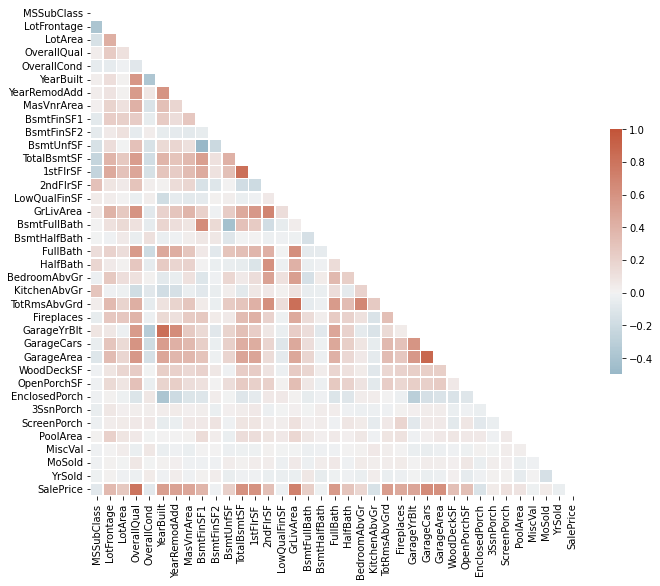

In [6]:
corr = train.corr()

mask = np.triu(np.ones_like(corr,dtype=bool))

f,ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,center=0,square=True, linewidths=.5,cbar_kws={"shrink":.5})

In [12]:
def data_transformation(data):
    
    if "saleprice_cat" in data.columns:
        data=data.drop("saleprice_cat",axis=1)
    if "index" in data.columns:
        data=data.drop("index",axis=1)
    if "Id" in data.columns:
        data=data.drop("Id",axis=1)
    if "SalePrice" in data.columns:
        labels = data["SalePrice"]
        data=data.drop("SalePrice",axis=1)
    else: labels=None
    
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")
    cat_imputer = SimpleImputer(strategy="most_frequent")

    data_num = data.select_dtypes(include=[np.number])
    data_cat = data.select_dtypes(exclude=[np.number])
    
    data_imputed = imputer.fit_transform(data_num)
    data_cat_imputed = cat_imputer.fit_transform(data_cat)

    from sklearn.preprocessing import OneHotEncoder
    cat_encoder = OneHotEncoder(sparse=False)
    data_enc = cat_encoder.fit_transform(data_cat_imputed)
    
    
    categories= [x for sublist in cat_encoder.categories_ for x in sublist]
    features = list(data_num.columns) + categories
    
    output = np.hstack([data_imputed,data_enc])
    return output,labels,features

In [19]:
#forenklet versjon av preprossesseringen av data som dropper en god del features og står igjen med kun numeriske features
def data_transformation_simple(data):
    
    if "SalePrice" in data.columns:
        labels = data["SalePrice"]
        data=data.drop("SalePrice",axis=1)
    else:
        labels=None
    unwanted=['index','Id','MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
   'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
   'OverallCond', 'RoofStyle',
   'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
   'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
   'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
   'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC',
   'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF',
   'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
   'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
   'Functional', 'FireplaceQu', 'GarageType', 
   'GarageFinish', 'GarageQual', 'GarageCond',
   'PavedDrive', 'EnclosedPorch', '3SsnPorch',
   'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
   'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'saleprice_cat']
    for feat in unwanted:
        if feat in data.columns:
            data=data.drop(feat,axis=1)
    
    
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")
    cat_imputer = SimpleImputer(strategy="most_frequent")

    data_num = data.select_dtypes(include=[np.number])
    
    data_imputed = imputer.fit_transform(data_num)
    
    features = list(data_num.columns)
    output = np.hstack([data_imputed])
    return output,labels,features

In [20]:
train_data, train_labels, train_features = data_transformation(train)
simple_data,simple_labels,simple_features = data_transformation_simple(train)

In [24]:
final_data = train_data[:1000,:]
final_labels = train_labels[:1000]
test_data = train_data[:(len(train_data)-1000),:]
test_labels = train_labels[:(len(train_data)-1000)]

In [25]:
final_simple_data = simple_data[:1000,:]
final_simple_labels = simple_labels[:1000]
simple_test_data = simple_data[:(len(simple_data)-1000),:]
simple_test_labels = simple_labels[:(len(simple_data)-1000)]

In [28]:
#rmse med "standarde" preprossesseringen
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100,random_state=3)
final_model = forest_reg.fit(final_data,final_labels) 

org_values = test_labels
predicted_values = final_model.predict(test_data)
forest_mse = mean_squared_error(org_values,predicted_values)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

10387.533721123731

In [29]:
#rmse med forenklet preprossessring
final_model = forest_reg.fit(final_simple_data,final_simple_labels) 

org_values = simple_test_labels
predicted_values = final_model.predict(simple_test_data)
forest_mse = mean_squared_error(org_values,predicted_values)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

11438.274499516117

In [103]:
from joblib import dump
dump(final_model,'rf_model.joblib')

['rf_model.joblib']